add photo here - maybe of books? or a library card? 

# A Data-driven Approach for Library Inventory ?? idk if i like this
### Author: Sarah Prusaitis

## Project Overview

This project aims to enhance inventory management at the Seattle Public Library by leveraging historical checkout data of both physical and digital books. By analyzing trends and patterns in the dataset spanning 2022-2023, the project seeks to provide actionable recommendations for optimizing the library's collection. Through predictive modeling, it aims to forecast future demand for various titles, enabling the library to better allocate resources and meet the needs of its patrons efficiently.

## Business Understanding

The primary objective of this project is to assist the Seattle Public Library in optimizing its inventory management system. By analyzing historical checkout data, the project aims to address the challenge of efficiently allocating resources for physical and digital book collections. The library's stakeholders seek insights into trends and preferences among its patrons to anticipate future demand accurately. Through predictive analytics, the project will deliver actionable recommendations to XYZ ( still deciding )

## Data Understanding

The dataset provided by The Seattle Public Library comprises 5.21 million rows and 12 columns, documenting the checkout records of both physical and electronic items over the years 2022 and 2023. Each row represents the number of checkouts for a specific title in a given month of the year. With this rich dataset, the project endeavors to understand the borrowing patterns of library users and identify key factors influencing the demand for books in both formats.

In [1]:
#import needed packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
pd.set_option('display.max_colwidth', 1000)

In [3]:
# Reading in data and looking at head

df = pd.read_csv('Data/Checkouts_by_Title_2022_2023.csv', low_memory = False)
df.head()

,UsageClass,CheckoutType,MaterialType,CheckoutYear,CheckoutMonth,Checkouts,Title,ISBN,Creator,Subjects,Publisher,PublicationYear
0,Physical,Horizon,BOOK,2022,9,6,Great day for up! Pictures by Quentin Blake.,"0394829131, 0394929136","Seuss, Dr.",Stories in rhyme,"Beginner Books,",[1974]
1,Digital,OverDrive,AUDIOBOOK,2022,9,1,"The Scientist and the Spy: A True Story of China, the FBI, and Industrial Espionage (unabridged)",9780593166819,Mara Hvistendahl,"Business, Politics, True Crime, Nonfiction",Books on Tape,2020
2,Digital,OverDrive,EBOOK,2022,9,3,The Flame and the Flower,9780061743696,Kathleen E. Woodiwiss,"Fiction, Romance, Historical Fiction",HarperCollins Publishers Inc.,2006
3,Digital,OverDrive,EBOOK,2022,9,8,Fifty Words for Rain: A Novel,9781524746377,Asha Lemmie,"Fiction, Literature, Historical Fiction","Penguin Group (USA), Inc.",2020
4,Physical,Horizon,BOOK,2022,9,5,How to code a rollercoaster / by Josh Funk ; illustrated by Sara Palacios ; foreword by Reshma Saujani.,"0425292037, 9780425292037","Funk, Josh","Amusement parks Juvenile fiction, Computer programming Juvenile fiction, Robots Juvenile fiction","Viking,",[2019]


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5207534 entries, 0 to 5207533
Data columns (total 12 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   UsageClass       object
 1   CheckoutType     object
 2   MaterialType     object
 3   CheckoutYear     int64 
 4   CheckoutMonth    int64 
 5   Checkouts        object
 6   Title            object
 7   ISBN             object
 8   Creator          object
 9   Subjects         object
 10  Publisher        object
 11  PublicationYear  object
dtypes: int64(2), object(10)
memory usage: 476.8+ MB


In [5]:
df['MaterialType'].value_counts()

BOOK                                          2061373
EBOOK                                         1679018
AUDIOBOOK                                      889842
VIDEODISC                                      313940
SOUNDDISC                                      225249
REGPRINT                                        15694
MUSIC                                            7673
LARGEPRINT                                       4576
SOUNDDISC, VIDEODISC                             2024
ER, SOUNDREC                                     1443
SOUNDREC                                         1054
ER                                                933
CR                                                905
MAP                                               702
VIDEO                                             699
ATLAS                                             430
ER, SOUNDDISC                                     429
ER, VIDEODISC                                     391
VISUAL                      

Filtering data to only physical books and digital books, LARGEPRINT is books that were printed in a larger font size to accomodate people with low vision. Upon looking at REGPRINT, they are physical books.

In [6]:
df.drop(df[~df['MaterialType'].isin(['BOOK', 'EBOOK', 'LARGEPRINT', 'REGPRINT'])].index, inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,UsageClass,CheckoutType,MaterialType,CheckoutYear,CheckoutMonth,Checkouts,Title,ISBN,Creator,Subjects,Publisher,PublicationYear
0,Physical,Horizon,BOOK,2022,9,6,Great day for up! Pictures by Quentin Blake.,"0394829131, 0394929136","Seuss, Dr.",Stories in rhyme,"Beginner Books,",[1974]
1,Digital,OverDrive,EBOOK,2022,9,3,The Flame and the Flower,9780061743696,Kathleen E. Woodiwiss,"Fiction, Romance, Historical Fiction",HarperCollins Publishers Inc.,2006
2,Digital,OverDrive,EBOOK,2022,9,8,Fifty Words for Rain: A Novel,9781524746377,Asha Lemmie,"Fiction, Literature, Historical Fiction","Penguin Group (USA), Inc.",2020
3,Physical,Horizon,BOOK,2022,9,5,How to code a rollercoaster / by Josh Funk ; illustrated by Sara Palacios ; foreword by Reshma Saujani.,"0425292037, 9780425292037","Funk, Josh","Amusement parks Juvenile fiction, Computer programming Juvenile fiction, Robots Juvenile fiction","Viking,",[2019]
4,Digital,OverDrive,EBOOK,2022,9,1,How to Be Yourself: Quiet Your Inner Critic and Rise Above Social Anxiety,9781250122230,Ellen Hendriksen,"Psychology, Self-Improvement, Nonfiction, Self Help",Macmillan Publishers,2018


In [7]:
# Combine 'CheckoutYear' and 'CheckoutMonth' into a datetime column and dropping unnecessary columns 

df['CheckoutDate'] = pd.to_datetime(df['CheckoutYear'].astype(str) + '-' + 
                                    df['CheckoutMonth'].astype(str), format='%Y-%m')
df.drop(['CheckoutYear', 'CheckoutMonth', 'CheckoutType', 'MaterialType'], axis=1, inplace = True)
df.head()

,UsageClass,Checkouts,Title,ISBN,Creator,Subjects,Publisher,PublicationYear,CheckoutDate
0,Physical,6,Great day for up! Pictures by Quentin Blake.,"0394829131, 0394929136","Seuss, Dr.",Stories in rhyme,"Beginner Books,",[1974],2022-09-01
1,Digital,3,The Flame and the Flower,9780061743696,Kathleen E. Woodiwiss,"Fiction, Romance, Historical Fiction",HarperCollins Publishers Inc.,2006,2022-09-01
2,Digital,8,Fifty Words for Rain: A Novel,9781524746377,Asha Lemmie,"Fiction, Literature, Historical Fiction","Penguin Group (USA), Inc.",2020,2022-09-01
3,Physical,5,How to code a rollercoaster / by Josh Funk ; illustrated by Sara Palacios ; foreword by Reshma Saujani.,"0425292037, 9780425292037","Funk, Josh","Amusement parks Juvenile fiction, Computer programming Juvenile fiction, Robots Juvenile fiction","Viking,",[2019],2022-09-01
4,Digital,1,How to Be Yourself: Quiet Your Inner Critic and Rise Above Social Anxiety,9781250122230,Ellen Hendriksen,"Psychology, Self-Improvement, Nonfiction, Self Help",Macmillan Publishers,2018,2022-09-01


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3760661 entries, 0 to 3760660
Data columns (total 9 columns):
 #   Column           Dtype         
---  ------           -----         
 0   UsageClass       object        
 1   Checkouts        object        
 2   Title            object        
 3   ISBN             object        
 4   Creator          object        
 5   Subjects         object        
 6   Publisher        object        
 7   PublicationYear  object        
 8   CheckoutDate     datetime64[ns]
dtypes: datetime64[ns](1), object(8)
memory usage: 258.2+ MB


In [9]:
# Changing the Checkouts column to be numeric instead of a string

df['Checkouts'] = df['Checkouts'].str.replace(',', '').astype(int)

In [10]:
# Checking how many null values in each column 

df.isnull().sum()

UsageClass              0
Checkouts               0
Title                   0
ISBN               639454
Creator            101247
Subjects            27281
Publisher           12668
PublicationYear     12323
CheckoutDate            0
dtype: int64

In [11]:
# Drop rows where 'Creator' column is null
df.dropna(subset=['Creator'], inplace=True)

In [12]:
# Clean and standardize PublicationYear column (leaves only year in YYYY format)

df['PublicationYear'] = df['PublicationYear'].str.extract(r'(\d{4})')

In [13]:
# Replace any missing publication years with 0000 

df['PublicationYear'].fillna("0000", inplace=True)

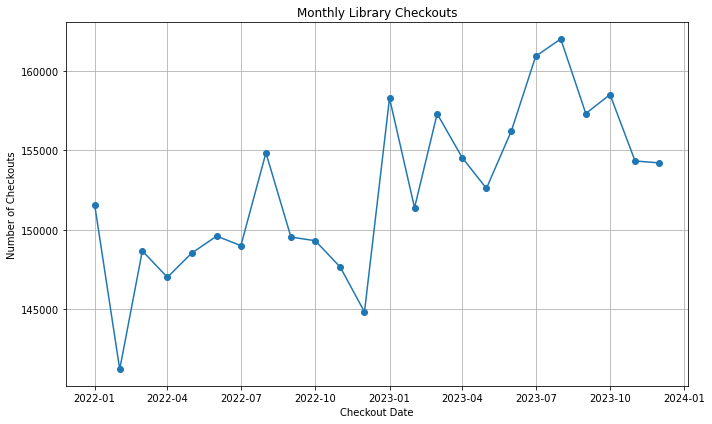

In [14]:
# Grouping by month and looking at the number of checkouts per month

monthly_checkouts = df.groupby(df['CheckoutDate'].dt.to_period('M')).size()

plt.figure(figsize=(10, 6))
plt.plot(monthly_checkouts.index.to_timestamp(), monthly_checkouts.values, marker='o', linestyle='-')
plt.title('Monthly Library Checkouts')
plt.xlabel('Checkout Date')
plt.ylabel('Number of Checkouts')
plt.grid(True)
plt.xticks()
plt.tight_layout()
plt.show()

In [15]:
df['Creator'].value_counts().head()

James Patterson            5573
Patterson, James, 1947-    4197
Nora Roberts               3706
Geronimo Stilton           3479
DK                         3263
Name: Creator, dtype: int64

In [16]:
# Standardizing the 'Creator' column so all authors names are in the same format

def standardize_creator(name):
    if isinstance(name, str):  # Check if the value is a string
        # Remove any additional information in parentheses
        if '(' in name and ')' in name:
            name = name.split(' (')[0]  # Extract primary name
        # Remove numbers
        name = re.sub(r'\d+', '', name)
        # Remove dashes if not part of a hyphenated name
        name = re.sub(r'(?<![a-zA-Z0-9])-|-(?![a-zA-Z0-9])', '', name)
        # If the name is in the format "Last, First"
        if ',' in name:
            parts = name.split(',')
            # If there is a comma after the first name
            if len(parts) > 2:
                name = parts[0] + ',' + ''.join(parts[1:])
            return name.strip()
        # If the name is in the format "First Last"
        elif ' ' in name:
            parts = name.split(' ')
            last = parts[-1]  # Last word is considered as the last name
            first = ' '.join(parts[:-1])  # Join the remaining as first name
            return f"{last}, {first}"
        else:
            return name.strip()
    else:
        return name

# Applying the function to standardize the 'Creator' column and replacing any null values

df['Creator'] = df['Creator'].apply(standardize_creator)
# df['Creator'].fillna('Unknown', inplace = True)

In [17]:
# Sanity check to make sure function ran correctly 

df['Creator'].value_counts().head()

Patterson, James      9770
Stilton, Geronimo     5903
Hunter, Erin          5179
Christie, Agatha      4959
Osborne, Mary Pope    4801
Name: Creator, dtype: int64

In [18]:
# Changing Creators names to be in the format firstname lastname and removing any punctuation

df['Creator'] = df['Creator'].apply(lambda x: ' '.join(x.split(',')[::-1]).strip())
df['Creator'] = df['Creator'].str.replace(r'[^\w\s.]', '')

In [19]:
df.head()

,UsageClass,Checkouts,Title,ISBN,Creator,Subjects,Publisher,PublicationYear,CheckoutDate
0,Physical,6,Great day for up! Pictures by Quentin Blake.,"0394829131, 0394929136",Dr. Seuss,Stories in rhyme,"Beginner Books,",1974,2022-09-01
1,Digital,3,The Flame and the Flower,9780061743696,Kathleen E. Woodiwiss,"Fiction, Romance, Historical Fiction",HarperCollins Publishers Inc.,2006,2022-09-01
2,Digital,8,Fifty Words for Rain: A Novel,9781524746377,Asha Lemmie,"Fiction, Literature, Historical Fiction","Penguin Group (USA), Inc.",2020,2022-09-01
3,Physical,5,How to code a rollercoaster / by Josh Funk ; illustrated by Sara Palacios ; foreword by Reshma Saujani.,"0425292037, 9780425292037",Josh Funk,"Amusement parks Juvenile fiction, Computer programming Juvenile fiction, Robots Juvenile fiction","Viking,",2019,2022-09-01
4,Digital,1,How to Be Yourself: Quiet Your Inner Critic and Rise Above Social Anxiety,9781250122230,Ellen Hendriksen,"Psychology, Self-Improvement, Nonfiction, Self Help",Macmillan Publishers,2018,2022-09-01


In [20]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3659414 entries, 0 to 3760660
Data columns (total 9 columns):
 #   Column           Dtype         
---  ------           -----         
 0   UsageClass       object        
 1   Checkouts        int64         
 2   Title            object        
 3   ISBN             object        
 4   Creator          object        
 5   Subjects         object        
 6   Publisher        object        
 7   PublicationYear  object        
 8   CheckoutDate     datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 279.2+ MB


In [21]:
df['Title'] = df['Title'].apply(lambda x: re.split(r'/(?!\d)', x)[0])


In [22]:
df['Title'] = df['Title'].str.replace(r'[^\w\s-]', '')


In [23]:
# Replace multiple hyphens with one space
df['Title'] = df['Title'].str.replace(r'(-)+', ' ')

In [24]:
# Remove "A Novel" from the 'Title' column
df['Title'] = df['Title'].str.replace(r'(?i)\bA Novel\b', '')

# Remove leading and trailing whitespaces from the 'Title' column
df['Title'] = df['Title'].str.strip()

# Capitalize only the first letter in each word in the 'Title' column
df['Title'] = df['Title'].str.title()

In [25]:
df['Title'].head()

0                                  Great Day For Up Pictures By Quentin Blake
1                                                    The Flame And The Flower
2                                                        Fifty Words For Rain
3                                                 How To Code A Rollercoaster
4    How To Be Yourself Quiet Your Inner Critic And Rise Above Social Anxiety
Name: Title, dtype: object

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3659414 entries, 0 to 3760660
Data columns (total 9 columns):
 #   Column           Dtype         
---  ------           -----         
 0   UsageClass       object        
 1   Checkouts        int64         
 2   Title            object        
 3   ISBN             object        
 4   Creator          object        
 5   Subjects         object        
 6   Publisher        object        
 7   PublicationYear  object        
 8   CheckoutDate     datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 279.2+ MB


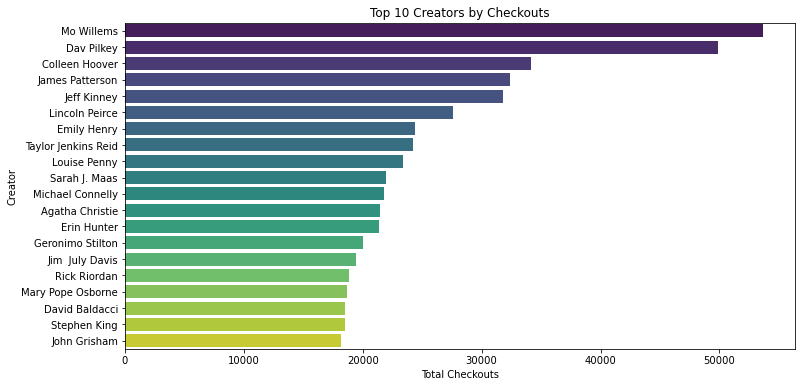

In [27]:
# Grouping data by 'Creator' and calculating total checkouts for each creator
creator_checkouts = df.groupby('Creator')['Checkouts'].sum().reset_index()

# Sorting creators by total checkouts in descending order
creator_checkouts = creator_checkouts.sort_values(by='Checkouts', ascending=False)

# Plotting the distribution of checkouts for top creators
plt.figure(figsize=(12, 6))
top_creators = creator_checkouts.head(20)  # Top 10 creators
sns.barplot(x='Checkouts', y='Creator', data=top_creators, palette='viridis')
plt.title('Top 10 Creators by Checkouts')
plt.xlabel('Total Checkouts')
plt.ylabel('Creator')
plt.show()

In [28]:
creator_checkouts

,Creator,Checkouts
98160,Mo Willems,53639
28945,Dav Pilkey,49917
25549,Colleen Hoover,34120
57077,James Patterson,32385
60159,Jeff Kinney,31773
...,...,...
84145,Louis William Steinwedel,1
57264,James Sully,1
57261,James Stuart,1
109262,Prole,1


In [29]:
df['Creator'].value_counts()

James Patterson       9770
Geronimo Stilton      5903
Erin Hunter           5179
Agatha Christie       4959
Mary Pope Osborne     4801
                      ... 
E.C. Frey                1
Chris Larsgaard          1
Lawrence D. Graham       1
亨利斯莱萨                    1
Kazuko Sashida           1
Name: Creator, Length: 143734, dtype: int64

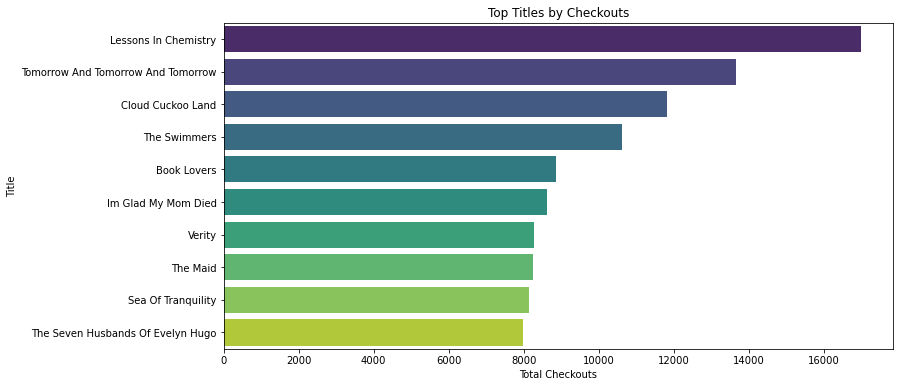

In [33]:
# Grouping data by 'Title' and calculating total checkouts for each title
title_creator_checkouts = df.groupby(['Title', 'Creator'])['Checkouts'].sum().reset_index()

# Sorting creators by total checkouts in descending order
title_creator_checkouts = title_creator_checkouts.sort_values(by='Checkouts', ascending=False)


# Plotting the distribution of checkouts for top titles
plt.figure(figsize=(12, 6))
top_titles = title_creator_checkouts.head(10)  # Top 10 titles
sns.barplot(x='Checkouts', y='Title', data=top_titles, palette='viridis')
plt.title('Top Titles by Checkouts')
plt.xlabel('Total Checkouts')
plt.ylabel('Title')
plt.show()

In [35]:
title_creator_checkouts.head(10)

,Title,Creator,Checkouts
173539,Lessons In Chemistry,Bonnie Garmus,17002
380950,Tomorrow And Tomorrow And Tomorrow,Gabrielle Zevin,13655
66920,Cloud Cuckoo Land,Anthony Doerr,11833
362629,The Swimmers,Julie Otsuka,10626
49567,Book Lovers,Emily Henry,8861
150038,Im Glad My Mom Died,Jennette McCurdy,8622
392776,Verity,Colleen Hoover,8266
335457,The Maid,Nita Prose,8252
255115,Sea Of Tranquility,Emily St. John Mandel,8135
356650,The Seven Husbands Of Evelyn Hugo,Taylor Jenkins Reid,7982


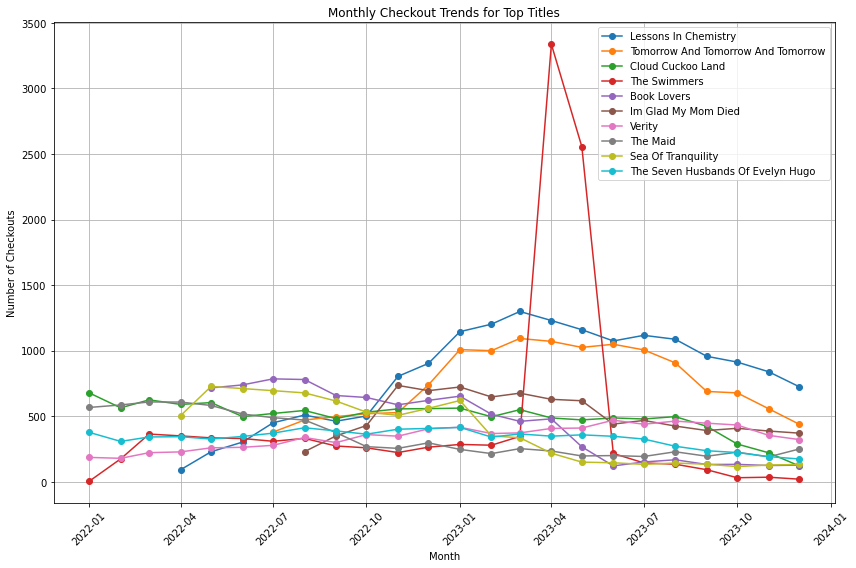

In [34]:
# Define a list of top titles
top_titles_list = title_creator_checkouts.head(10)['Title'].tolist()

# Filter the dataframe to include only the top titles
top_titles_df = df[df['Title'].isin(top_titles_list)]

# Group by 'Title', 'CheckoutDate' and sum up the checkouts
title_monthly_checkouts = top_titles_df.groupby(['Title', df['CheckoutDate'].dt.to_period('M')])['Checkouts'].sum().reset_index()

# Plot checkout trends for each top title
plt.figure(figsize=(12, 8))
for title in top_titles_list:
    title_data = title_monthly_checkouts[title_monthly_checkouts['Title'] == title]
    plt.plot(title_data['CheckoutDate'].dt.to_timestamp(), title_data['Checkouts'], label=title, marker='o')

plt.title('Monthly Checkout Trends for Top Titles')
plt.xlabel('Month')
plt.ylabel('Number of Checkouts')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()